# Data Pre-processing & Modeling and Evaluation

- **Data Pre-processing**: Cleaning, Feature Engineering, Transformation, Feature Selection
- **Modeling and Evaluation**: Model training, hyperparameter tuning, evaluation, and comparison



# Pre-processing Stage


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data
df = pd.read_csv('ML_Exercise_Data.txt', sep='\t')
df.head()


,originator,beneficiary,date,time,type,currency,value,aggregate_value,aggregate_volume,flag
0,MBKJMPXX,AOHNGHXX,190101,647,MT103,CNY,103026,0.4762,1.9317,0
1,NNKIGLXX,DFHGAUXX,190101,701,MT103,MZN,26287,0.4242,1.0421,0
2,MBKJMPXX,KCMNMPXX,190101,718,MT103,EGP,1451540,1.9299,0.6000,0
3,NNKIGLXX,WJPNGLXX,190101,722,MT202,TJS,55888,0.2774,0.3810,0
4,NNKIGLXX,HUAPGLXX,190101,750,MT202,TTD,149993,1.0218,0.7619,0



## Data Cleaning


In [3]:
# Extract country codes
df['originator_country'] = df['originator'].str[4:6]
df['beneficiary_country'] = df['beneficiary'].str[4:6]
df.drop(['originator', 'beneficiary'], axis=1, inplace=True)

# Convert date and extract hour
df['date'] = pd.to_datetime(df['date'], format='%y%m%d')
df['hour'] = df['time'] // 100
df.drop(['date', 'time'], axis=1, inplace=True)

# Check for missing values
missing_summary = df.isnull().sum()
print(missing_summary[missing_summary > 0])

# Drop rows with missing values
df.dropna(inplace=True)
print(f"Data shape after dropping missing values: {df.shape}")

# Check updated data types and preview
print(df.dtypes)
df.head()


Series([], dtype: int64)
Data shape after dropping missing values: (99615, 9)
type                    object
currency                object
value                    int64
aggregate_value        float64
aggregate_volume       float64
flag                     int64
originator_country      object
beneficiary_country     object
hour                     int64
dtype: object


,type,currency,value,aggregate_value,aggregate_volume,flag,originator_country,beneficiary_country,hour
0,MT103,CNY,103026,0.4762,1.9317,0,MP,GH,6
1,MT103,MZN,26287,0.4242,1.0421,0,GL,AU,7
2,MT103,EGP,1451540,1.9299,0.6000,0,MP,MP,7
3,MT202,TJS,55888,0.2774,0.3810,0,GL,GL,7
4,MT202,TTD,149993,1.0218,0.7619,0,GL,GL,7



## Feature Engineering
- Apply transformations like log scaling to reduce skewness and encode categorical variables.

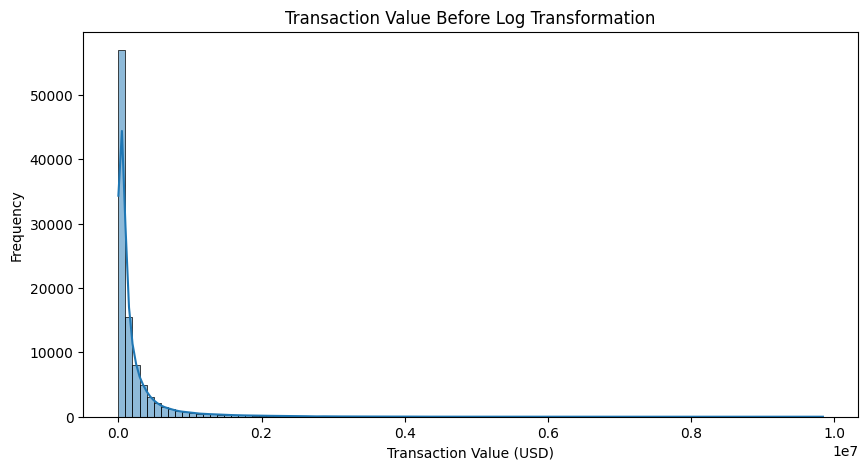

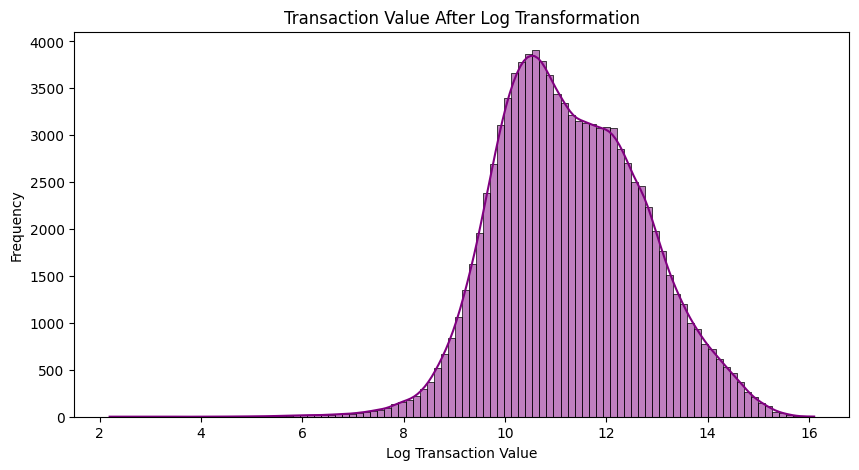

,value,aggregate_value,aggregate_volume,flag,hour,value_log,aggregate_value_log,aggregate_volume_log,originator_country_enc,beneficiary_country_enc,currency_enc,type_enc
0,103026,0.4762,1.9317,0,6,11.542746,0.389471,1.075582,2,9,2,0
1,26287,0.4242,1.0421,0,7,10.176868,0.353610,0.713979,1,0,10,0
2,1451540,1.9299,0.6000,0,7,14.188136,1.074968,0.470004,2,16,4,0
3,55888,0.2774,0.3810,0,7,10.931123,0.244827,0.322808,1,11,14,1
4,149993,1.0218,0.7619,0,7,11.918351,0.703988,0.566393,1,11,15,1


In [4]:
# Distribution before log transformation
plt.figure(figsize=(10,5))
sns.histplot(df['value'], bins=100, kde=True)
plt.title('Transaction Value Before Log Transformation')
plt.xlabel('Transaction Value (USD)')
plt.ylabel('Frequency')
plt.show()

# Log Transformation
df['value_log'] = np.log1p(df['value'])
df['aggregate_value_log'] = np.log1p(df['aggregate_value'])
df['aggregate_volume_log'] = np.log1p(df['aggregate_volume'])

# Distribution after log transformation
plt.figure(figsize=(10,5))
sns.histplot(df['value_log'], bins=100, kde=True, color='purple')
plt.title('Transaction Value After Log Transformation')
plt.xlabel('Log Transaction Value')
plt.ylabel('Frequency')
plt.show()

# Encoding categorical variables
le = LabelEncoder()
df['originator_country_enc'] = le.fit_transform(df['originator_country'])
df['beneficiary_country_enc'] = le.fit_transform(df['beneficiary_country'])
df['currency_enc'] = le.fit_transform(df['currency'])
df['type_enc'] = le.fit_transform(df['type'])

# Drop original categorical columns
df = df.drop(['originator_country', 'beneficiary_country', 'currency', 'type'], axis=1)

# Preview the data
df.head()



## Outlier Detection
- To detect and cap extreme values using IQR method


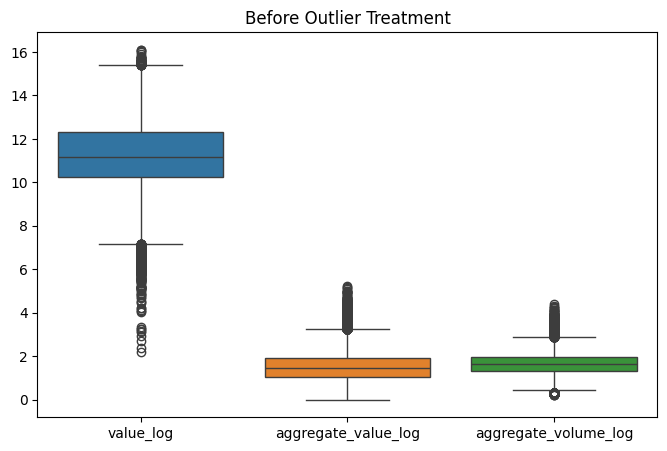

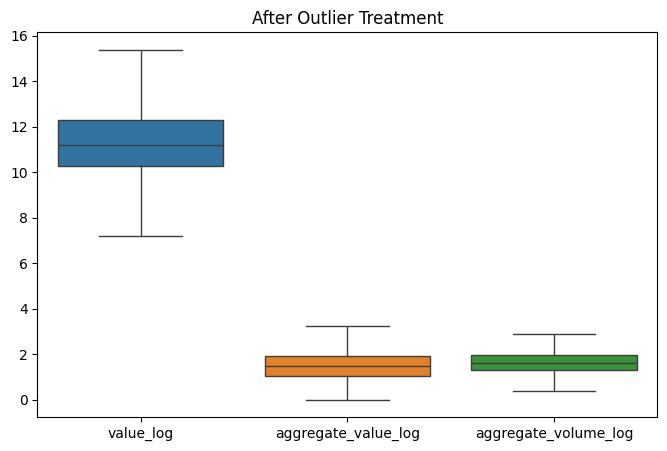

In [5]:
# Outlier Detection using IQR
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

# Before capping
plt.figure(figsize=(8,5))
sns.boxplot(data=df[['value_log', 'aggregate_value_log', 'aggregate_volume_log']])
plt.title('Before Outlier Treatment')
plt.show()

# Apply capping
for col in ['value_log', 'aggregate_value_log', 'aggregate_volume_log']:
    df = cap_outliers(df, col)

# After capping
plt.figure(figsize=(8,5))
sns.boxplot(data=df[['value_log', 'aggregate_value_log', 'aggregate_volume_log']])
plt.title('After Outlier Treatment')
plt.show()




## Data Transformation


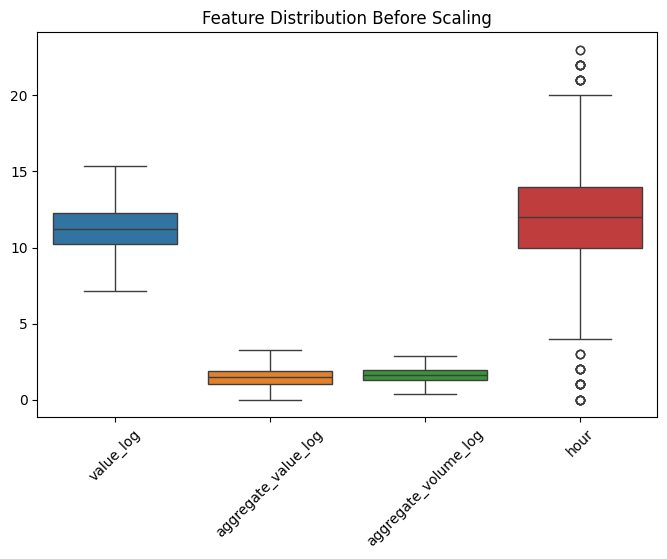

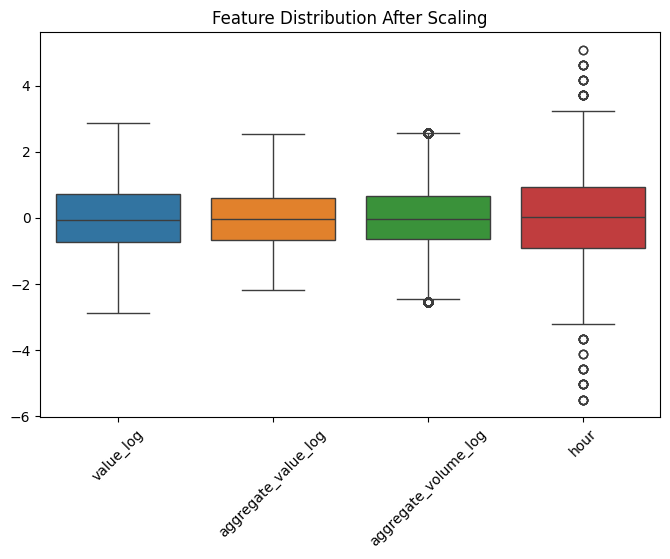

,value,aggregate_value,aggregate_volume,flag,hour,value_log,aggregate_value_log,aggregate_volume_log,originator_country_enc,beneficiary_country_enc,currency_enc,type_enc
0,103026,0.4762,1.9317,0,-2.740175,0.174470,-1.621424,-1.134561,2,9,2,0
1,26287,0.4242,1.0421,0,-2.279991,-0.779878,-1.673753,-1.871467,1,0,10,0
2,1451540,1.9299,0.6000,0,-2.279991,2.022821,-0.621133,-2.368660,2,16,4,0
3,55888,0.2774,0.3810,0,-2.279991,-0.252875,-1.832493,-2.557659,1,11,14,1
4,149993,1.0218,0.7619,0,-2.279991,0.436907,-1.162475,-2.172230,1,11,15,1


In [6]:
# Boxplot before scaling
plt.figure(figsize=(8,5))
sns.boxplot(data=df[['value_log', 'aggregate_value_log', 'aggregate_volume_log', 'hour']])
plt.title('Feature Distribution Before Scaling')
plt.xticks(rotation=45)
plt.show()

# Standard Scaling
scaler = StandardScaler()
num_features = ['value_log', 'aggregate_value_log', 'aggregate_volume_log', 'hour']
df[num_features] = scaler.fit_transform(df[num_features])

# Boxplot after scaling
plt.figure(figsize=(8,5))
sns.boxplot(data=df[['value_log', 'aggregate_value_log', 'aggregate_volume_log', 'hour']])
plt.title('Feature Distribution After Scaling')
plt.xticks(rotation=45)
plt.show()

# Preview the data
df.head()



## Feature Selection
- Select the most importatn/relevant features

- ANOVA (Analysis of Variance) F-test assesses the statistical significance of each feature by measuring the ratio of between-group variance to within-group variance, indicating how well a feature differentiates between classes

-  A higher F-statistic indicates a stronger relationship between the feature and the target, meaning the feature is more important for predicting the target variable

F-statistics: [3.04911988e+03 7.62624672e+03 3.63875181e+03 9.67114625e-03
 2.04077548e+03 2.57166462e+03 1.36880090e+03 2.57901305e+02
 3.39943525e+01 5.94387722e+00 3.79744292e+02]
***************************************************************************
P-values: [0.00000000e+000 0.00000000e+000 0.00000000e+000 9.21660937e-001
 0.00000000e+000 0.00000000e+000 1.34497923e-297 5.81996452e-058
 5.54421134e-009 1.47702315e-002 2.03346818e-084]
***************************************************************************
Selector Score: [3.04911988e+03 7.62624672e+03 3.63875181e+03 9.67114625e-03
 2.04077548e+03 2.57166462e+03 1.36880090e+03 2.57901305e+02
 3.39943525e+01 5.94387722e+00 3.79744292e+02]


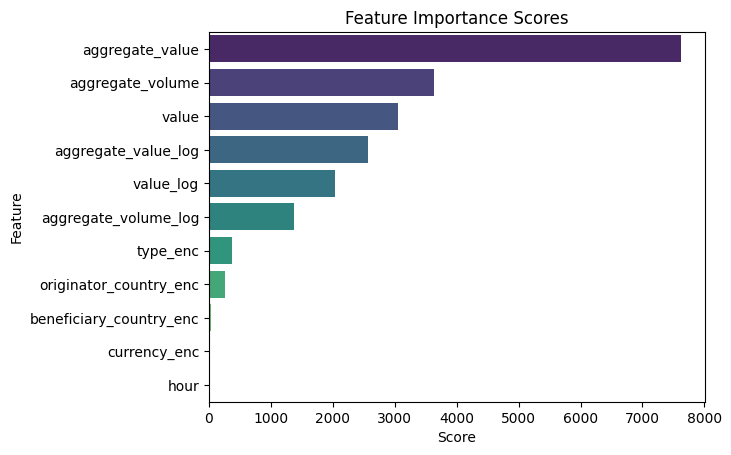

,Feature,Score
1,aggregate_value,7626.246716
2,aggregate_volume,3638.751805
0,value,3049.119879
5,aggregate_value_log,2571.664618
4,value_log,2040.775478
6,aggregate_volume_log,1368.800900
10,type_enc,379.744292
7,originator_country_enc,257.901305
8,beneficiary_country_enc,33.994353
9,currency_enc,5.943877


In [7]:
# Define features and target
X = df.drop('flag', axis=1)
y = df['flag']

# Calculate F-statistics and p-values
f_values, p_values = f_classif(X, y)
# F-statistics and p-values
print("F-statistics:", f_values)
print("*" * 75)
print("P-values:", p_values)
print("*" * 75)

# Feature selection using ANOVA F-test
# SelectKBest: Selects the top-k features based on the scoring function (f_classif)
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit_transform(X, y)
print("Selector Score:",selector.scores_)

feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_}).sort_values(by='Score', ascending=False)
sns.barplot(data=feature_scores, x='Score', y='Feature', palette='viridis')
plt.title('Feature Importance Scores')
plt.show()

feature_scores


## Save Pre-Processed Data


In [8]:
df.to_csv('preprocessed_Data.csv', index=False)
print("Pre-processed data saved successfully - 'preprocessed_Data.csv'")


Pre-processed data saved successfully - 'preprocessed_Data.csv'



# Modeling and Evaluation Stage


In [37]:
# Import libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from imblearn.over_sampling import SMOTE


In [10]:
# Load Pre-Processed Data
df = pd.read_csv('preprocessed_Data.csv')
X = df.drop('flag', axis=1)
y = df['flag']

# SMOTE for imbalance handling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)


## Model Selection 

Evaluate and compare the following models:

- **Logistic Regression**: A simple linear model good for baseline
- **Random Forest**: Ensemble learning using multiple decision trees
- **XGBoost**: Gradient boosting optimized for speed and performance
- **LightGBM**: Gradient boosting optimized for large datasets
- **Support Vector Machine (SVM)**: Finds the optimal hyperplane to separate classes

- Balanced dataset using **SMOTE**


In [14]:
# Define Pipelines
pipelines = {
    'LogisticRegression': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))]),
    'RandomForest': Pipeline([('clf', RandomForestClassifier(class_weight='balanced'))]),
    'XGBoost': Pipeline([('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1))]),
    'LightGBM': Pipeline([('clf', LGBMClassifier(class_weight='balanced'))]),
    #'SVM': Pipeline([('scaler', StandardScaler()), ('clf', SVC(probability=True, class_weight='balanced'))])
}



## Hyper-parameter Tuning and Training


In [15]:
# Parameter values
param_grids = {
    'LogisticRegression': {'clf__C': [0.01, 0.1, 1, 10]},
    'RandomForest': {'clf__n_estimators': [100, 200], 'clf__max_depth': [5, 10, 20]},
    'XGBoost': {'clf__n_estimators': [100, 200], 'clf__max_depth': [3, 6, 10]},
    'LightGBM': {'clf__n_estimators': [100, 200], 'clf__max_depth': [5, 10]},
    #'SVM': {'clf__C': [0.1, 1, 10], 'clf__kernel': ['linear', 'rbf']}
}

# GridSearch
best_models = {}
for name, pipeline in pipelines.items():
    print(f"Tuning {name}...")
    grid = GridSearchCV(pipeline, param_grids[name], cv=3, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"Best params for {name}: {grid.best_params_}")


Tuning LogisticRegression...
Best params for LogisticRegression: {'clf__C': 10}
Tuning RandomForest...
Best params for RandomForest: {'clf__max_depth': 20, 'clf__n_estimators': 200}
Tuning XGBoost...
Best params for XGBoost: {'clf__max_depth': 10, 'clf__n_estimators': 200}
Tuning LightGBM...
[LightGBM] [Info] Number of positive: 68566, number of negative: 68566
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 137132, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best params for LightGBM: {'clf__max_depth': 10, 'clf__n_estimators': 200}


In [29]:
best_models['XGBoost']

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])


## Model Evaluation


Evaluating LogisticRegression...
Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85     29386
           1       0.87      0.82      0.85     29386

    accuracy                           0.85     58772
   macro avg       0.85      0.85      0.85     58772
weighted avg       0.85      0.85      0.85     58772



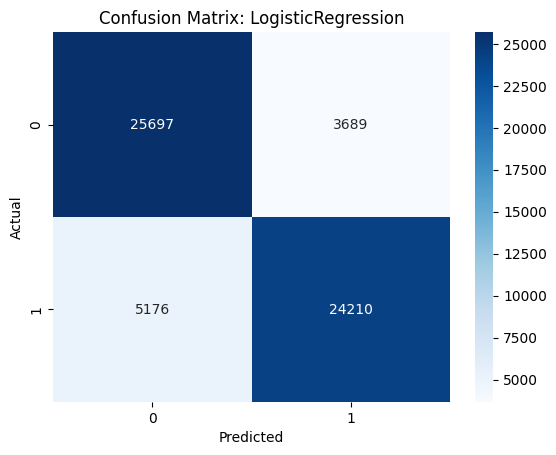

ROC AUC Score: 0.9233


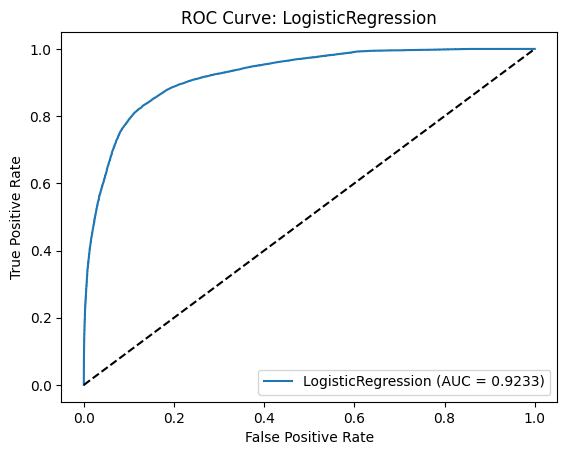

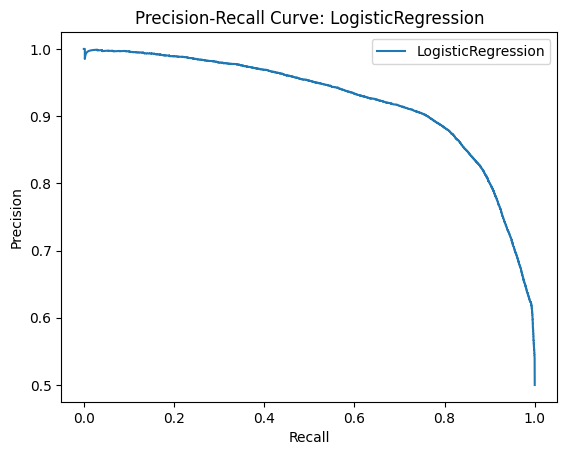

Evaluating RandomForest...
Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     29386
           1       0.98      0.99      0.98     29386

    accuracy                           0.98     58772
   macro avg       0.98      0.98      0.98     58772
weighted avg       0.98      0.98      0.98     58772



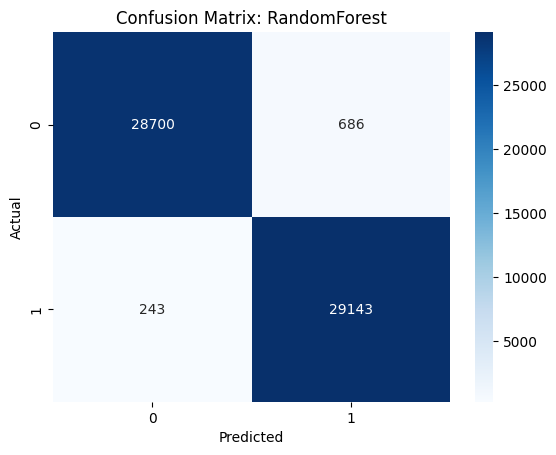

ROC AUC Score: 0.9985


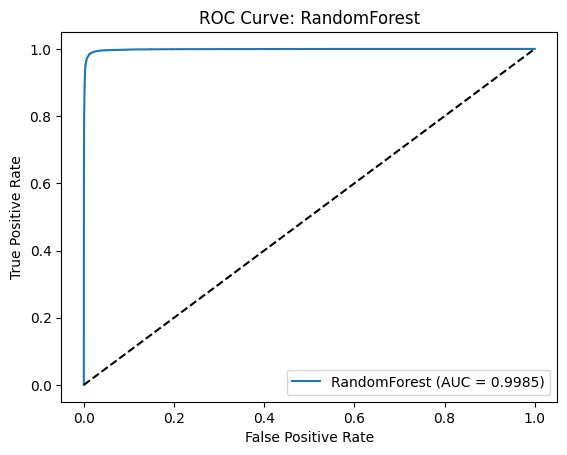

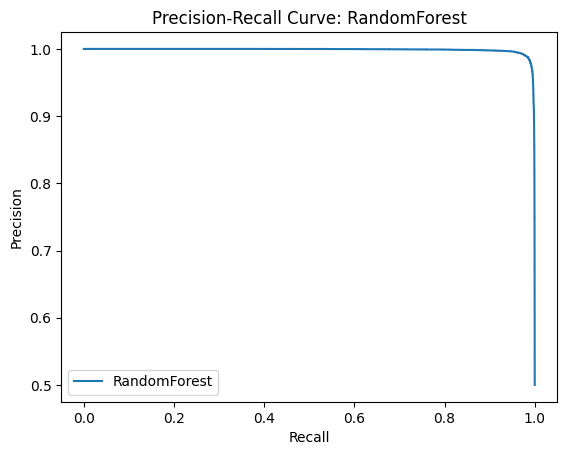

Evaluating XGBoost...
Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     29386
           1       1.00      0.99      0.99     29386

    accuracy                           0.99     58772
   macro avg       0.99      0.99      0.99     58772
weighted avg       0.99      0.99      0.99     58772



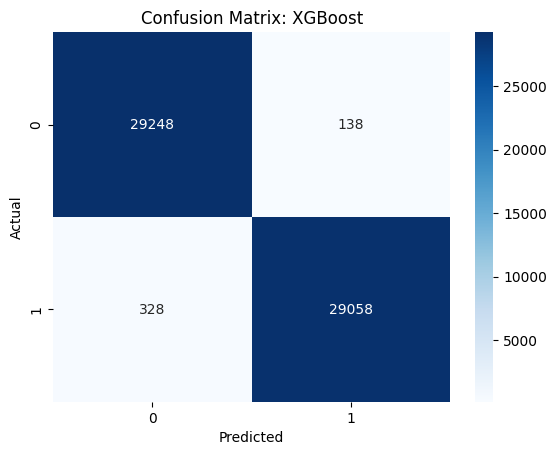

ROC AUC Score: 0.9990


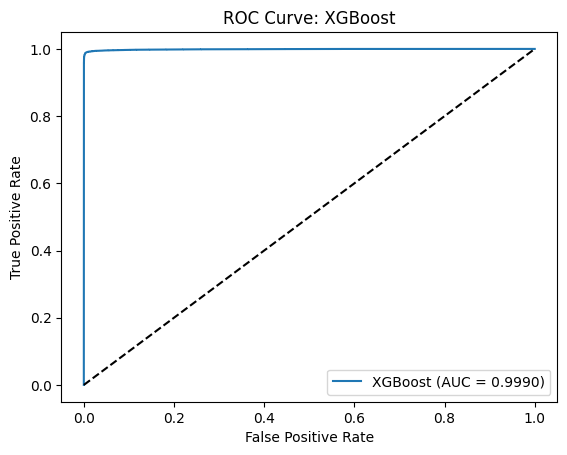

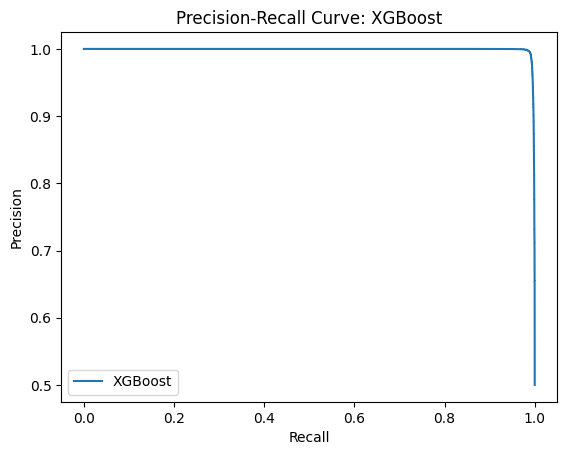

Evaluating LightGBM...
Classification Report for LightGBM:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     29386
           1       0.99      0.98      0.99     29386

    accuracy                           0.99     58772
   macro avg       0.99      0.99      0.99     58772
weighted avg       0.99      0.99      0.99     58772



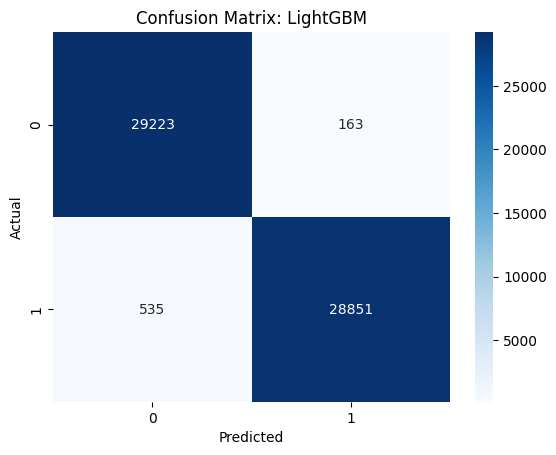

ROC AUC Score: 0.9984


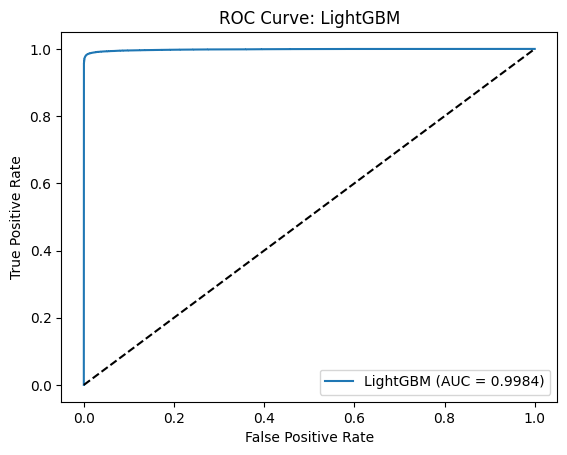

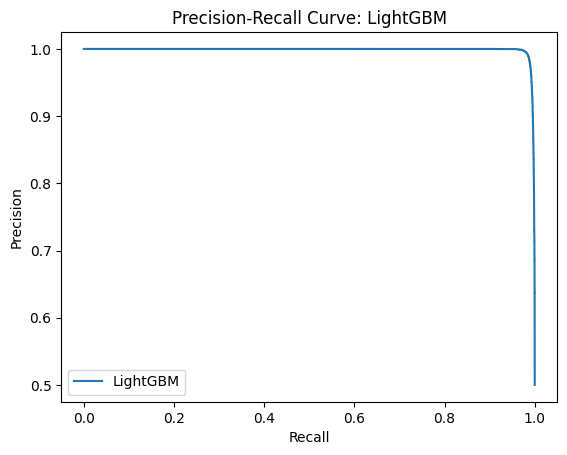

In [20]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    auc_score = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend(loc='lower right')
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label=f'{model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {model_name}')
    plt.legend()
    plt.show()


# Evaluate all models
model_results = {}
for name, model in best_models.items():
    print(f"Evaluating {name}...")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_proba)
    model_results[name] = auc
    evaluate_model(model, X_test, y_test, name)

Precision [0.5        0.50000851 0.50001702 ... 1.         1.         1.        ]
********************************************************************************
Recall [1.         1.         1.         ... 0.1754577  0.11362554 0.        ]
********************************************************************************
Thresholds [1.8464057e-08 4.9784255e-08 9.7013782e-08 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
********************************************************************************
Best Threshold: 0.5350
Best F1 Score: 0.9922


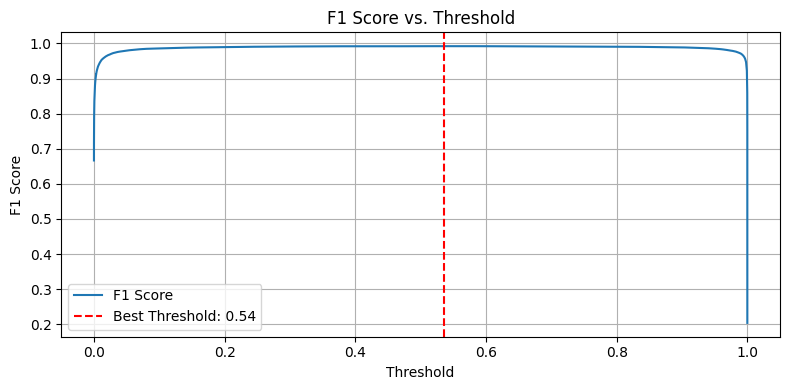

In [41]:
# Calculate Precision-Recall pairs for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, best_models['XGBoost'].predict_proba(X_test)[:,1])
print("Precision", precision)
print("*" * 80)
print("Recall", recall)
print("*" * 80)
print("Thresholds", thresholds)
print("*" * 80)

# F1 Score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # Adding 1e-8 to avoid division by zero

# Find the best threshold
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f'Best Threshold: {best_threshold:.4f}')
print(f'Best F1 Score: {best_f1:.4f}')

# Plot F1 Score vs Threshold
plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## Model Comparison


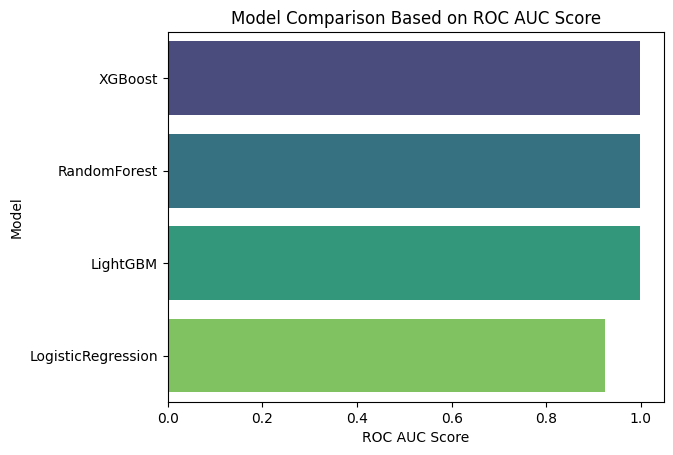

,Model,ROC AUC Score
2,XGBoost,0.998956
1,RandomForest,0.998540
3,LightGBM,0.998371
0,LogisticRegression,0.923312


In [23]:
# Compare all models
results_df = pd.DataFrame(list(model_results.items()), columns=['Model', 'ROC AUC Score']).sort_values(by='ROC AUC Score', ascending=False)
sns.barplot(data=results_df, x='ROC AUC Score', y='Model', palette='viridis')
plt.title('Model Comparison Based on ROC AUC Score')
plt.show()
results_df


*******************************
## Key Metrics
- **Accuracy**: Overall correctness
- **Precision**: Correctly predicted frauds out of all predicted frauds (Correct positive frauds)
- **Recall**: (Sensitivity): Correctly predicted frauds out of all actual frauds (Important to catch as many frauds as possible)
- **F1-Score**: Balance precision and recall
- **ROC AUC**: Area under ROC curve — higher is better
- **Precision-Recall Curve**: Focused evaluation for imbalanced data


**Conclusion**: Models with high ROC AUC and Recall values which minimizing false negatives
***********************************

## Save the Model

In [28]:
import joblib

# Save the trained best model
joblib.dump(best_models['XGBoost'], 'best_model.pkl')
print("Model saved successfully as 'best_model.pkl'")

Model saved successfully as 'best_model.pkl'


************************************************************************

# Run Fraud Detection System

In [2]:
!streamlit run fraud_detection_app.py